# **Covid19 segmentation and 3D reconstruction**

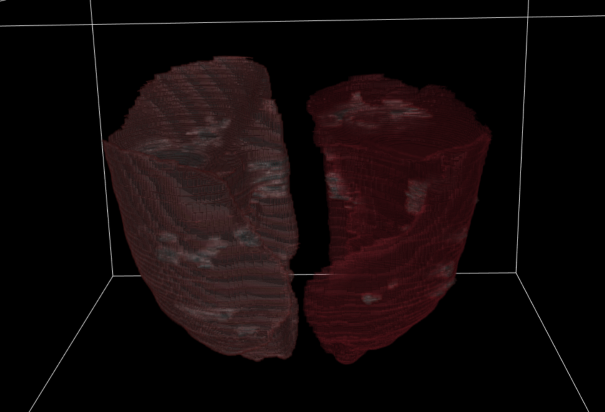

content
--------------------

model:
* Unet
* Unet with ResNext50 architecture

trick:
* BCELOSS, DiceLoss, FocalLoss
* albumentations augumentation
* gradient accumulation

visualize:
* 3d reconstruction

You could download parameters(Unet, trained less than 40 epochs,you could see it as a baseline) from this site : https://www.kaggle.com/qiyuange/covid19-unet-weightpytorch

By the way, if you find this notebook helpful, please **Upvote**(Thank you!)

In [1]:
import torch
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torch.nn.functional as F
import torchvision
from albumentations import Compose,Resize,OneOf,RandomBrightness,RandomContrast,Normalize,HorizontalFlip,Blur,ElasticTransform,GridDistortion,OpticalDistortion,GaussNoise 
from albumentations.pytorch import ToTensor
import pandas as pd
import numpy as np
import nibabel as nib
from PIL import Image
import time
import matplotlib.pyplot as plt
import cv2
import copy
from tqdm import tqdm_notebook as tqdm

In [2]:
seed = 271
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset

In [3]:
class Covid19_CT_Dataset(torch.utils.data.Dataset):
    def __init__(self, cts_path, masks_path, transform=None, transform2=None):
        self.transforms = transform
        self.transforms2 = transform2
        self.cts_path = cts_path
        self.masks_path = masks_path
        self.len = np.array(nib.load(self.cts_path).get_fdata()).shape[-1]
        
    def __getitem__(self,index):
        ct = nib.load(self.cts_path)
        ct = np.rot90(np.array(ct.get_fdata()))
        image = ct[:,:,index]
        image = Image.fromarray(image)
        image = np.array(image.convert('RGB'))
        
        ct_mask = nib.load(self.masks_path)
        ct_mask = np.rot90(np.array(ct_mask.get_fdata()))
        mask = ct_mask[:,:,index]
        
        labels = np.unique(mask).astype("uint8")
        labels = labels[1:]
        target_mask = np.zeros((mask.shape[0], mask.shape[1], 3))
        for label in labels:
            target_mask[:,:, label-1 : label] = np.expand_dims(mask, -1)==label
        
        if self.transforms is not None:
            augument = self.transforms(image=image,mask=target_mask)
            image = augument['image']
            target_mask = augument['mask']
            
        if self.transforms2 is not None:
            image = self.transforms2(image=image)['image']
        
        target_mask = ToTensor()(image=target_mask)['image']
        
        image = ToTensor()(image=image)['image']
        
        return image, target_mask
    
    def __len__(self):
        return self.len

# data augumentation

In [4]:
imgsize = 256
transforms = {
    'both': Compose([
                    Resize(imgsize,imgsize),
                    HorizontalFlip(p=0.5), 
                    OneOf([ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=120*0.03), GridDistortion(), OpticalDistortion(distort_limit=2, shift_limit=0.5)], p=0.3),
                    ]),
    
    'image': Compose([
                    OneOf([RandomBrightness(limit=0.1, p=0.4), RandomContrast(limit=0.1, p=0.4)]),
                    GaussNoise(),
                    Blur(p=0.1, blur_limit = 3),
                    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ]),
        

}

# visualize data

In [5]:
csv_file = r'../input/covid19-ct-scans/metadata.csv'
df = pd.read_csv(csv_file)
cts_path = df['ct_scan'].tolist()
masks_path = df['lung_and_infection_mask'].tolist()
dataset = Covid19_CT_Dataset(cts_path[0],masks_path[0],transform=transforms['both'], transform2=None)

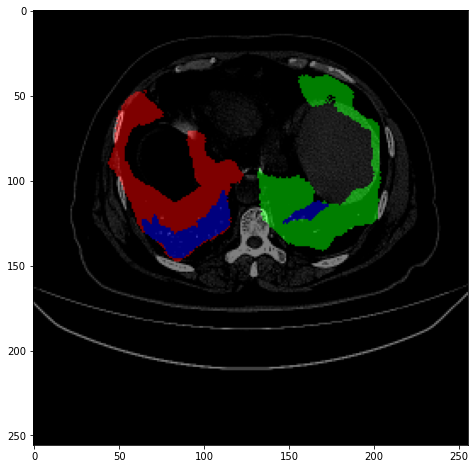

In [6]:
img_id = 100
plt.figure(figsize=(8,8))
plt.imshow(dataset[img_id][0].permute(1,2,0).numpy(), cmap='bone')
plt.imshow(dataset[img_id][1].permute(1,2,0).numpy(), alpha=0.5, cmap='Reds')

The green stands for left lung, red stands for right lung and blue stands for infection area

# DiceLoss, BCELoss, FocalLoss, IOU

In [7]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        BCE = nn.BCELoss()(inputs, targets)
        num = targets.size(0)     
        inputs = inputs.reshape(num, -1)
        targets = targets.reshape(num, -1)
        
        intersection = (inputs * targets).sum(1) 
        dice = (2.*intersection + smooth)/(inputs.sum(1) + targets.sum(1) + smooth) 
        dice_loss = 1 - dice.sum()/num

        loss_final = 3*BCE + dice_loss
        return loss_final
    
    

class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
              
        
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU * 100

    
    
class DiceScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceScore, self).__init__()

    def forward(self, inputs, targets, smooth=1):
              
        
        intersection = (inputs * targets).sum()                            
        dice_score = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) 
        return dice_score
    

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = 1
        self.gamma = 2
        
    def forward(self, inputs, targets):
        num = targets.size(0)
        inputs = inputs.reshape(num, -1)
        targets = targets.reshape(num, -1)
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        batch_loss = self.alpha * (1 - inputs) ** self.gamma * BCE_loss
        loss = batch_loss.mean()
        
        return loss

In [8]:
def compute_iou(model, loader, threshold=0.3):
    model.eval()
    valloss = 0
    
    with torch.no_grad():
        for data, target in loader:
            
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = DiceScore()(out_cut, target.data.cpu().numpy())
            valloss += picloss

    return valloss /len(loader)

# 1.Unet

Read More ->
U-Net: Convolutional Networks for Biomedical Image Segmentation 
https://arxiv.org/abs/1505.04597

In [9]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=(3,3),padding=1):
        super(ConvBlock,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size,padding=padding)
        self.batchnorm = nn.BatchNorm2d(out_channels,eps=1e-4)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x
        
        
class StackEncoder(nn.Module):
    def __init__(self,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackEncoder,self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.block = nn.Sequential(
            ConvBlock(channel1,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),     
        )
        
    def forward(self,x):
        copy_out = self.block(x)
        poolout = self.maxpool(copy_out)
        return copy_out,poolout
     
        
class StackDecoder(nn.Module):
    def __init__(self,copy_channel,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackDecoder,self).__init__()
        self.unConv = nn.ConvTranspose2d(channel1,channel1,kernel_size=(2,2),stride=2)
        self.block = nn.Sequential(
            ConvBlock(channel1+copy_channel,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),
        )
        
    def forward(self,x,down_copy):
            _, channels, height, width = down_copy.size()  
            x = self.unConv(x)
            x = torch.cat([x, down_copy], 1)
            x = self.block(x)
            return x
        
        
class Unet(nn.Module):
    def __init__(self):
        super(Unet,self).__init__()
        
        self.down1 = StackEncoder(3,32,kernel_size=(3,3))             
        self.down2 = StackEncoder(32,64,kernel_size=(3,3))            
        self.down3 = StackEncoder(64,128,kernel_size=(3,3))           
        self.down4 = StackEncoder(128,256,kernel_size=(3,3))          
        
        self.center = ConvBlock(256,256,kernel_size=(3,3),padding=1)  
        
        self.up4 = StackDecoder(256,256,128,kernel_size=(3,3))        
        self.up3 = StackDecoder(128,128,64,kernel_size=(3,3))         
        self.up2 = StackDecoder(64,64,32,kernel_size=(3,3))           
        self.up1 = StackDecoder(32,32,16,kernel_size=(3,3))           
        self.conv = Conv2d(16,3,kernel_size=(1,1),bias=True)
        
    def forward(self,x):
        copy1,out = self.down1(x)  
        copy2,out = self.down2(out)  
        copy3,out = self.down3(out)
        copy4,out = self.down4(out)
        
        out = self.center(out)
        
        up4 = self.up4(out,copy4)
        up3 = self.up3(up4,copy3)
        up2 = self.up2(up3,copy2)
        up1 = self.up1(up2,copy1)
        
        out = self.conv(up1)
        out = nn.Sigmoid()(out)


        return out

# 2.Unet with resnext50 architecture

You can also modify and improve it

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=(3,3),padding=1):
        super(ConvBlock,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size,padding=padding,bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels,eps=1e-5)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

    
    
class StackDecoder(nn.Module):
    def __init__(self,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackDecoder,self).__init__()
        self.unConv = nn.ConvTranspose2d(channel1,channel1,kernel_size=(2,2),stride=2)
        self.block = nn.Sequential(
            ConvBlock(channel1,channel1//2,kernel_size,padding),
            ConvBlock(channel1//2,channel2,kernel_size,padding),
        )
        
    def forward(self,x):
        x = self.unConv(x)
        x = self.block(x)
        return x

    
    
class ResNextUnet(nn.Module):
    def __init__(self):
        super(ResNextUnet,self).__init__()
        self.base_model = torchvision.models.resnext50_32x4d(pretrained=True)
        self.resblock = list(self.base_model.children())
        self.down0 = nn.Sequential(*self.resblock[:3])
        self.down1 = nn.Sequential(*self.resblock[4])
        self.down2 = nn.Sequential(*self.resblock[5])
        self.down3 = nn.Sequential(*self.resblock[6])
        self.down4 = nn.Sequential(*self.resblock[7])
        self.center = nn.Sequential(
            nn.Conv2d(2048, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(1024, eps=1e-05),
            nn.Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False),
            nn.BatchNorm2d(1024, eps=1e-05),
            nn.Conv2d(1024, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(2048, eps=1e-05),
            nn.ReLU(inplace=True)
        )
        self.up3 = StackDecoder(2048, 1024)
        self.up2 = StackDecoder(1024, 512)
        self.up1 = StackDecoder(512, 256)
        self.last_block = StackDecoder(256, 64, 3, 1)
        self.classifier = nn.Conv2d(64, 2, 3, padding=1)
                       
        
    def forward(self,x):
        d0 = self.down0(x)           #128     
        d1 = self.down1(d0)          #128
        d2 = self.down2(d1)          #64
        d3 = self.down3(d2)          #32
        d4 = self.down4(d3)          #16
        
        u4 = self.center(d4) + d4    #16
        u3 = self.up3(u4) + d3       #32
        u2 = self.up2(u3) + d2       #64
        u1 = self.up1(u2) + d1       #128
        
        out = self.last_block(u1)    #256
        out = self.classifier(out)
        out = nn.Sigmoid()(out)
        
        return out

# Train function

In [10]:
def train(model, criterion, optimizer, lr_scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100
    print_freq = int(len(dataloader['train'])/20)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train','val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 

            running_loss = 0.0
            size = 0
            pb = tqdm(dataloader[phase], total=len(dataloader[phase]))
            for i, (images, masks) in enumerate(pb):
                images = images.to(device)
                masks = masks.to(device)

                optimizer.zero_grad()       

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    loss = criterion[0](outputs, masks) + 4*criterion[1](outputs, masks)
                    loss = loss / accumulation_steps
                    if phase == 'train':
                        loss.backward()
                        if (i + 1 ) % accumulation_steps == 0:
                            optimizer.step()
                            lr_scheduler.step()

                running_loss += loss.item() * images.size(0)
                size += images.size(0)
                pb.set_postfix(loss=running_loss/size)
 
            epoch_loss = running_loss / dataset_size[phase]
            print()
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                
            elif phase == 'val':
                iou = compute_iou(model, dataloader[phase], threshold=0.3)
                print("DICE score : ", iou)
                val_loss.append(epoch_loss)
                
                
            if phase == 'val' and epoch_loss <= best_loss:
                print('New Optimal Found!')
                best_loss = epoch_loss
                torch.save(model.state_dict(), saved_path)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print()
    
    model.load_state_dict(best_model_wts)
    return model

In [11]:
csv_file = r'../input/covid19-ct-scans/metadata.csv'
df = pd.read_csv(csv_file)
cts_path = df['ct_scan'].tolist()
masks_path = df['lung_and_infection_mask'].tolist()
dataset_list = []
for i in range(20):
    dataset_list.append(Covid19_CT_Dataset(cts_path[i],masks_path[i],transform=transforms['both'], transform2=transforms['image']))
      
dataset_train = torch.utils.data.ConcatDataset(dataset_list[:16])
dataset_val = torch.utils.data.ConcatDataset(dataset_list[16:])


train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=8, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=8, shuffle=False, num_workers=2)
dataset_size = {'train':len(dataset_train), 'val':len(dataset_val)}
dataloader = {'train':train_loader, 'val':val_loader}

In [ ]:
train_loss = []
val_loss = []
accumulation_steps = 32//8  #8 is batch_size
model = Unet()
model.to(device)
criterion = [DiceBCELoss(), FocalLoss()]             
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

model = train(model, criterion, optimizer, lr_scheduler, num_epochs=70)

In [ ]:
#model_path = r'../input/covid19-unet-weightpytorch/covid19_Unet_seg.pth'
#model = Unet()
#model.load_state_dict(torch.load(model_path, map_location=device))
#model.to(device)
#model.eval()

# View Result

In [12]:
from IPython.display import Image

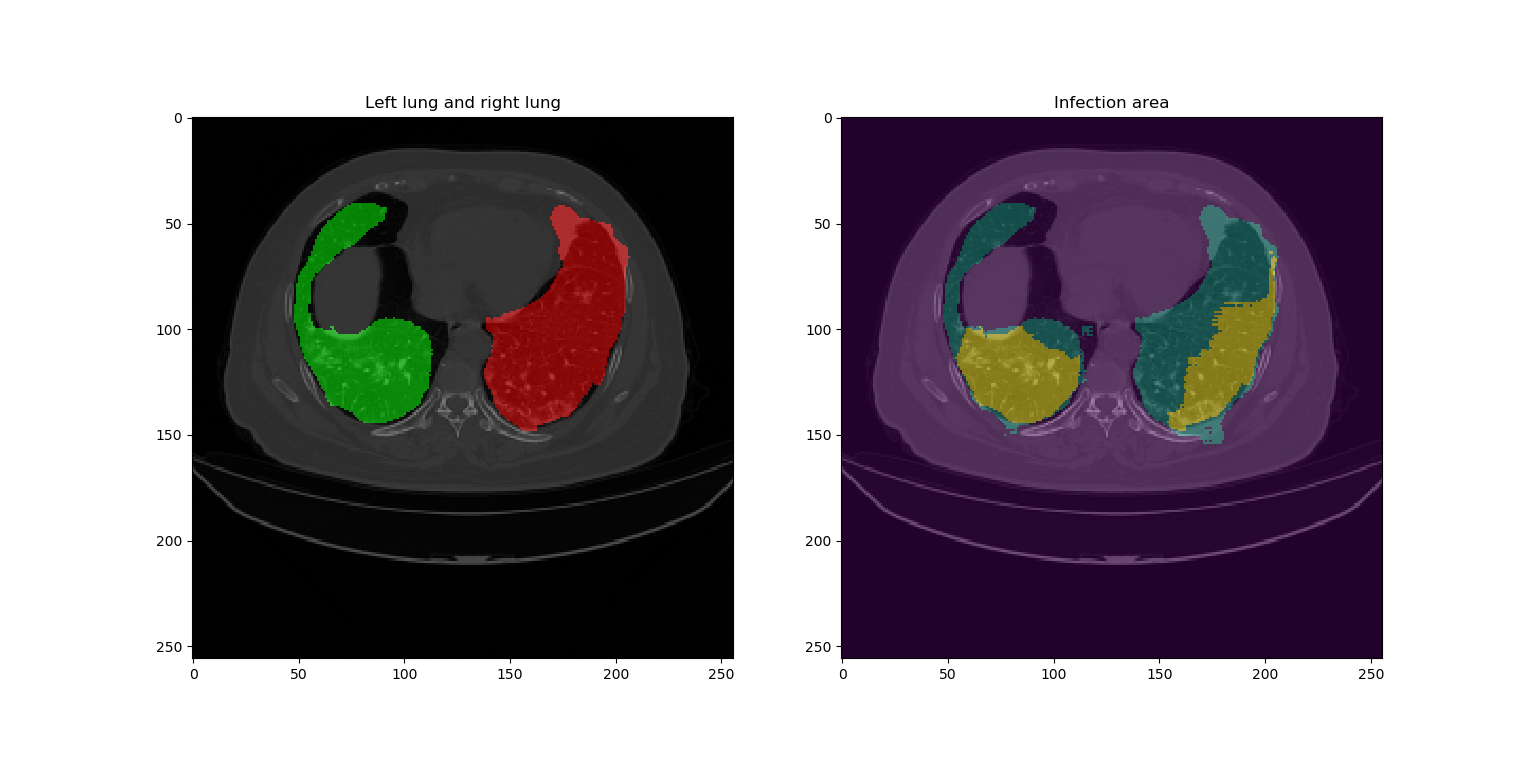

In [13]:
Image(r'../input/covid-19-display-image/covid19 display image/Figure_1.png')

# 3D Reconstruction

CT-scan

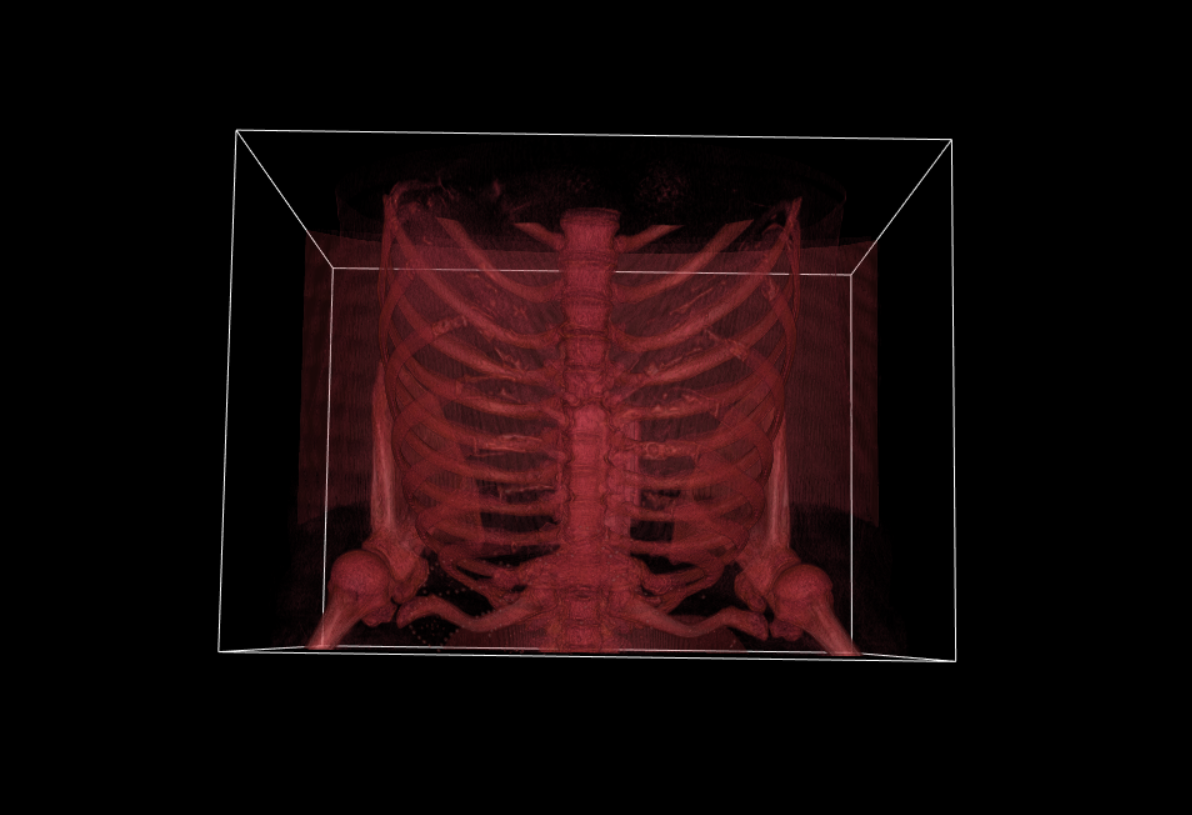

In [14]:
Image(r'../input/covid-19-display-image/covid19 display image/ct.PNG')

Lung and infection area

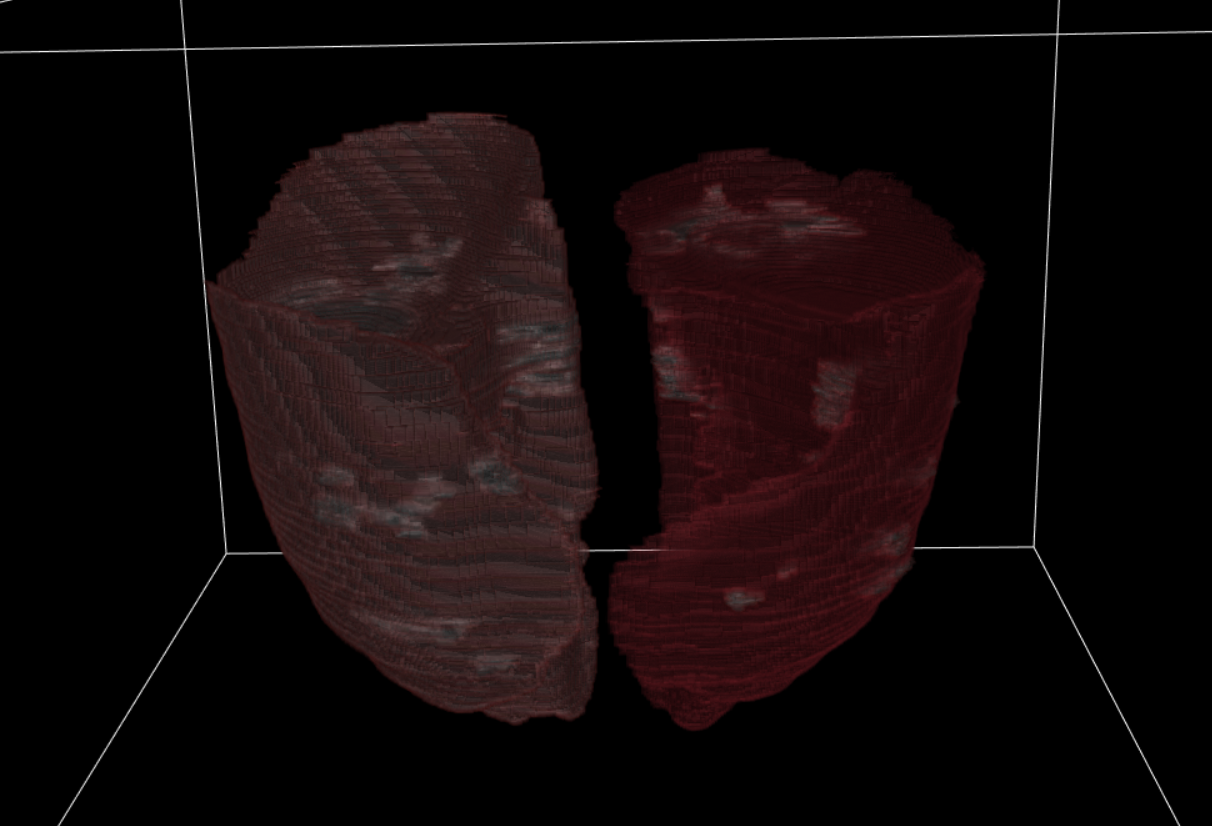

In [15]:
Image(r'../input/covid-19-display-image/covid19 display image/infection_and_lung.PNG')

Infection area

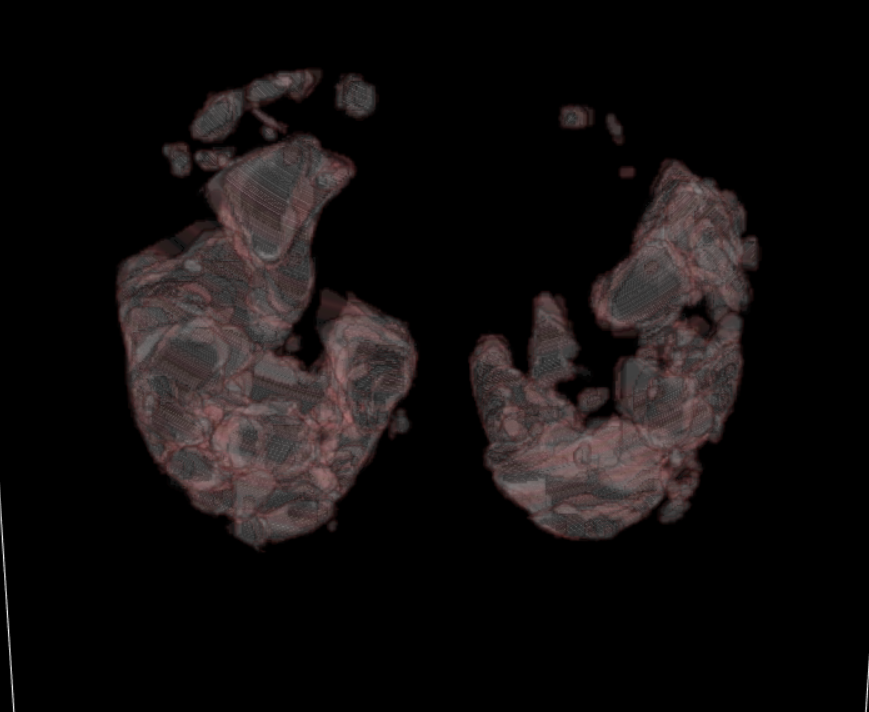

In [16]:
Image(r'../input/covid-19-display-image/covid19 display image/infection.PNG')

NOTE : If you want to try codes below yourself ,please download the notebook to your computer. 
I can't run it successfully on kaggle

In [ ]:
import vtk
from vtkmodules.util.vtkImageImportFromArray import *
import SimpleITK as sitk

In [ ]:
class KeyPressInteractorStyle(vtk.vtkInteractorStyleTrackballCamera):
     
    def __init__(self,parent=None):
        self.parent = vtk.vtkRenderWindowInteractor()
        if(parent is not None):
            self.parent = parent
 
        self.AddObserver("KeyPressEvent",self.keyPress)
 
    def keyPress(self,obj,event):
        key = self.parent.GetKeySym()
        if key == 'Up':
            
            gradtfun.AddPoint(-100, 1.0)
            gradtfun.AddPoint(10, 1.0)
            gradtfun.AddPoint(20, 1.0)
            
            volumeProperty.SetGradientOpacity(gradtfun)
            renWin.Render()
        if key == 'Down':
            
            tfun.AddPoint(1129, 0)
            tfun.AddPoint(1300.0, 0.1)
            tfun.AddPoint(1600.0, 0.2)
            tfun.AddPoint(2000.0, 0.1)
            tfun.AddPoint(2200.0, 0.1)
            tfun.AddPoint(2500.0, 0.1)
            tfun.AddPoint(2800.0, 0.1)
            tfun.AddPoint(3000.0, 0.1)
            renWin.Render()
    

def StartInteraction():
    renWin.SetDesiredUpdateRate(10)

def EndInteraction():
    renWin.SetDesiredUpdateRate(0.001)

def ClipVolumeRender(obj):
    obj.GetPlanes(planes)
    volumeMapper.SetClippingPlanes(planes)

In [ ]:
ds = sitk.ReadImage(path)
data = sitk.GetArrayFromImage(ds)  

spacing = ds.GetSpacing()            

srange = [np.min(data),np.max(data)]
img_arr = vtkImageImportFromArray()      
img_arr.SetArray(data)                   
img_arr.SetDataSpacing(spacing)           
origin = (0,0,0)
img_arr.SetDataOrigin(origin)             
img_arr.Update()   

ren = vtk.vtkRenderer()
renWin= vtk.vtkRenderWindow()
renWin.AddRenderer(ren)   
renWin.AddRenderer(ren)
iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin) 
iren.SetInteractorStyle(KeyPressInteractorStyle(parent = iren))
min = srange[0]
max = srange[1]
diff = max - min             
inter = 4200 / diff
shift = -min

shifter = vtk.vtkImageShiftScale() 
shifter.SetShift(shift)
shifter.SetScale(inter)
shifter.SetOutputScalarTypeToUnsignedShort()
shifter.SetInputData(img_arr.GetOutput())
shifter.ReleaseDataFlagOff()
shifter.Update()

tfun = vtk.vtkPiecewiseFunction()  
tfun.AddPoint(1129, 0)
tfun.AddPoint(1300.0, 0.1)
tfun.AddPoint(1600.0, 0.12)
tfun.AddPoint(2000.0, 0.13)
tfun.AddPoint(2200.0, 0.14)
tfun.AddPoint(2500.0, 0.16)
tfun.AddPoint(2800.0, 0.17)
tfun.AddPoint(3000.0, 0.18)

gradtfun = vtk.vtkPiecewiseFunction()  
gradtfun.AddPoint(-1000, 9)
gradtfun.AddPoint(0.5, 9.9)
gradtfun.AddPoint(1, 10)

ctfun = vtk.vtkColorTransferFunction()  
ctfun.AddRGBPoint(0.0, 0.5, 0.0, 0.0)
ctfun.AddRGBPoint(600.0, 1.0, 0.5, 0.5)
ctfun.AddRGBPoint(1280.0, 0.9, 0.2, 0.3)
ctfun.AddRGBPoint(1960.0, 0.81, 0.27, 0.1)
ctfun.AddRGBPoint(2200.0, 0.9, 0.2, 0.3)
ctfun.AddRGBPoint(2500.0, 1, 0.5, 0.5)
ctfun.AddRGBPoint(3024.0, 0.5, 0.5, 0.5)

volumeMapper = vtk.vtkGPUVolumeRayCastMapper()
volumeMapper.SetInputData(shifter.GetOutput())   
volumeProperty = vtk.vtkVolumeProperty()         
volumeProperty.SetColor(ctfun)  
volumeProperty.SetScalarOpacity(tfun)
volumeProperty.SetInterpolationTypeToLinear()    
volumeProperty.ShadeOn()            

newvol = vtk.vtkVolume()                      
newvol.SetMapper(volumeMapper)
newvol.SetProperty(volumeProperty)

outline = vtk.vtkOutlineFilter()
outline.SetInputConnection(shifter.GetOutputPort())

outlineMapper = vtk.vtkPolyDataMapper()
outlineMapper.SetInputConnection(outline.GetOutputPort())

outlineActor = vtk.vtkActor()
outlineActor.SetMapper(outlineMapper)

ren.AddActor(outlineActor)
ren.AddVolume(newvol)
ren.SetBackground(0, 0, 0)
renWin.SetSize(600, 600)

planes = vtk.vtkPlanes()

boxWidget = vtk.vtkBoxWidget()
boxWidget.SetInteractor(iren)
boxWidget.SetPlaceFactor(1.0)
boxWidget.PlaceWidget(0,0,0,0,0,0)
boxWidget.InsideOutOn()
boxWidget.AddObserver("StartInteractionEvent", StartInteraction)
boxWidget.AddObserver("InteractionEvent",  ClipVolumeRender)
boxWidget.AddObserver("EndInteractionEvent",  EndInteraction)

outlineProperty = boxWidget.GetOutlineProperty()
outlineProperty.SetRepresentationToWireframe()
outlineProperty.SetAmbient(1.0)
outlineProperty.SetAmbientColor(1, 1, 1)
outlineProperty.SetLineWidth(9)

selectedOutlineProperty = boxWidget.GetSelectedOutlineProperty()
selectedOutlineProperty.SetRepresentationToWireframe()
selectedOutlineProperty.SetAmbient(1.0)
selectedOutlineProperty.SetAmbientColor(1, 0, 0)
selectedOutlineProperty.SetLineWidth(3)

ren.ResetCamera()
iren.Initialize()
renWin.Render()
iren.Start()

In this part, I used code from this blog(it's my first time use vtk, thanks), which is : https://blog.csdn.net/weixin_42724859/article/details/103615980?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522160134702319724848316641%2522%252C%2522scm%2522%253A%252220140713.130102334.pc%255Fall.%2522%257D&request_id=160134702319724848316641&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~first_rank_ecpm_v3~pc_rank_v2-3-103615980.first_rank_ecpm_v3_pc_rank_v2&utm_term=vtk+%E4%B8%89%E7%BB%B4%E9%87%8D%E5%BB%BA+python&spm=1018.2118.3001.4187 